In [1]:
# 📦 Standard imports
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scanpy figure settings for consistency
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=100, frameon=True, figsize=(8, 8))


In [2]:
# 🚀 Load the processed pancancer single-cell dataset
adata = sc.read("../../data/processed/pancancer_dimred.h5ad")

# 🪐 Explore the structure for orientation
print("🧬 AnnData shape (cells x genes):", adata.shape)
print("\n📋 .obs preview:")
print(adata.obs.head())

print("\n🔎 .obs columns:")
print(adata.obs.columns.tolist())

print("\n🧬 .var (genes):", adata.var.shape)
print("📋 .var columns:", adata.var.columns.tolist())

print("\n📚 Layers available:", list(adata.layers.keys()))
print("\n🧠 Dimensionality reductions available:", list(adata.obsm.keys()))
print("\n🔗 .obs index (first 5):", adata.obs.index[:5].tolist())


🧬 AnnData shape (cells x genes): (39715, 30314)

📋 .obs preview:
                         size_factors  total_counts cell_line cell_line_norm  \
C32_SKIN                     0.598491   3937.553223       C32            C32   
NCIH446_LUNG                 0.404451   3395.153320   NCIH446        NCIH446   
MFE319_ENDOMETRIUM           1.081174   4233.473633    MFE319         MFE319   
SKNAS_AUTONOMIC_GANGLIA      0.694279   3880.139648     SKNAS          SKNAS   
NCIH2452_PLEURA              0.926227   3827.817871  NCIH2452       NCIH2452   

                              SIDM  
C32_SKIN                 SIDM00890  
NCIH446_LUNG             SIDM00965  
MFE319_ENDOMETRIUM       SIDM00333  
SKNAS_AUTONOMIC_GANGLIA  SIDM01101  
NCIH2452_PLEURA          SIDM00722  

🔎 .obs columns:
['size_factors', 'total_counts', 'cell_line', 'cell_line_norm', 'SIDM']

🧬 .var (genes): (30314, 6)
📋 .var columns: ['highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_nor

In [3]:
# 🩺 Load tissue dummy matrix for tissue annotation
tissue_df = pd.read_csv("../02_feature_engineering/feature_engineering/processed_tissue_dummies.csv")

# Extract tissue labels from dummy columns
tissue_cols = [col for col in tissue_df.columns if col.startswith("Tissue_")]
tissue_df["Tissue"] = tissue_df[tissue_cols].idxmax(axis=1).str.replace("Tissue_", "")

# Map using SIDM identifiers
tissue_map = tissue_df.set_index("SANGER_MODEL_ID")["Tissue"]

# Add to AnnData
adata.obs["Tissue"] = adata.obs["SIDM"].map(tissue_map)

print("✅ Tissue annotation added:")
print(adata.obs[["SIDM", "Tissue"]].head())


✅ Tissue annotation added:
                              SIDM                     Tissue
C32_SKIN                 SIDM00890                       Skin
NCIH446_LUNG             SIDM00965                       Lung
MFE319_ENDOMETRIUM       SIDM00333                Endometrium
SKNAS_AUTONOMIC_GANGLIA  SIDM01101  Peripheral Nervous System
NCIH2452_PLEURA          SIDM00722                       Lung


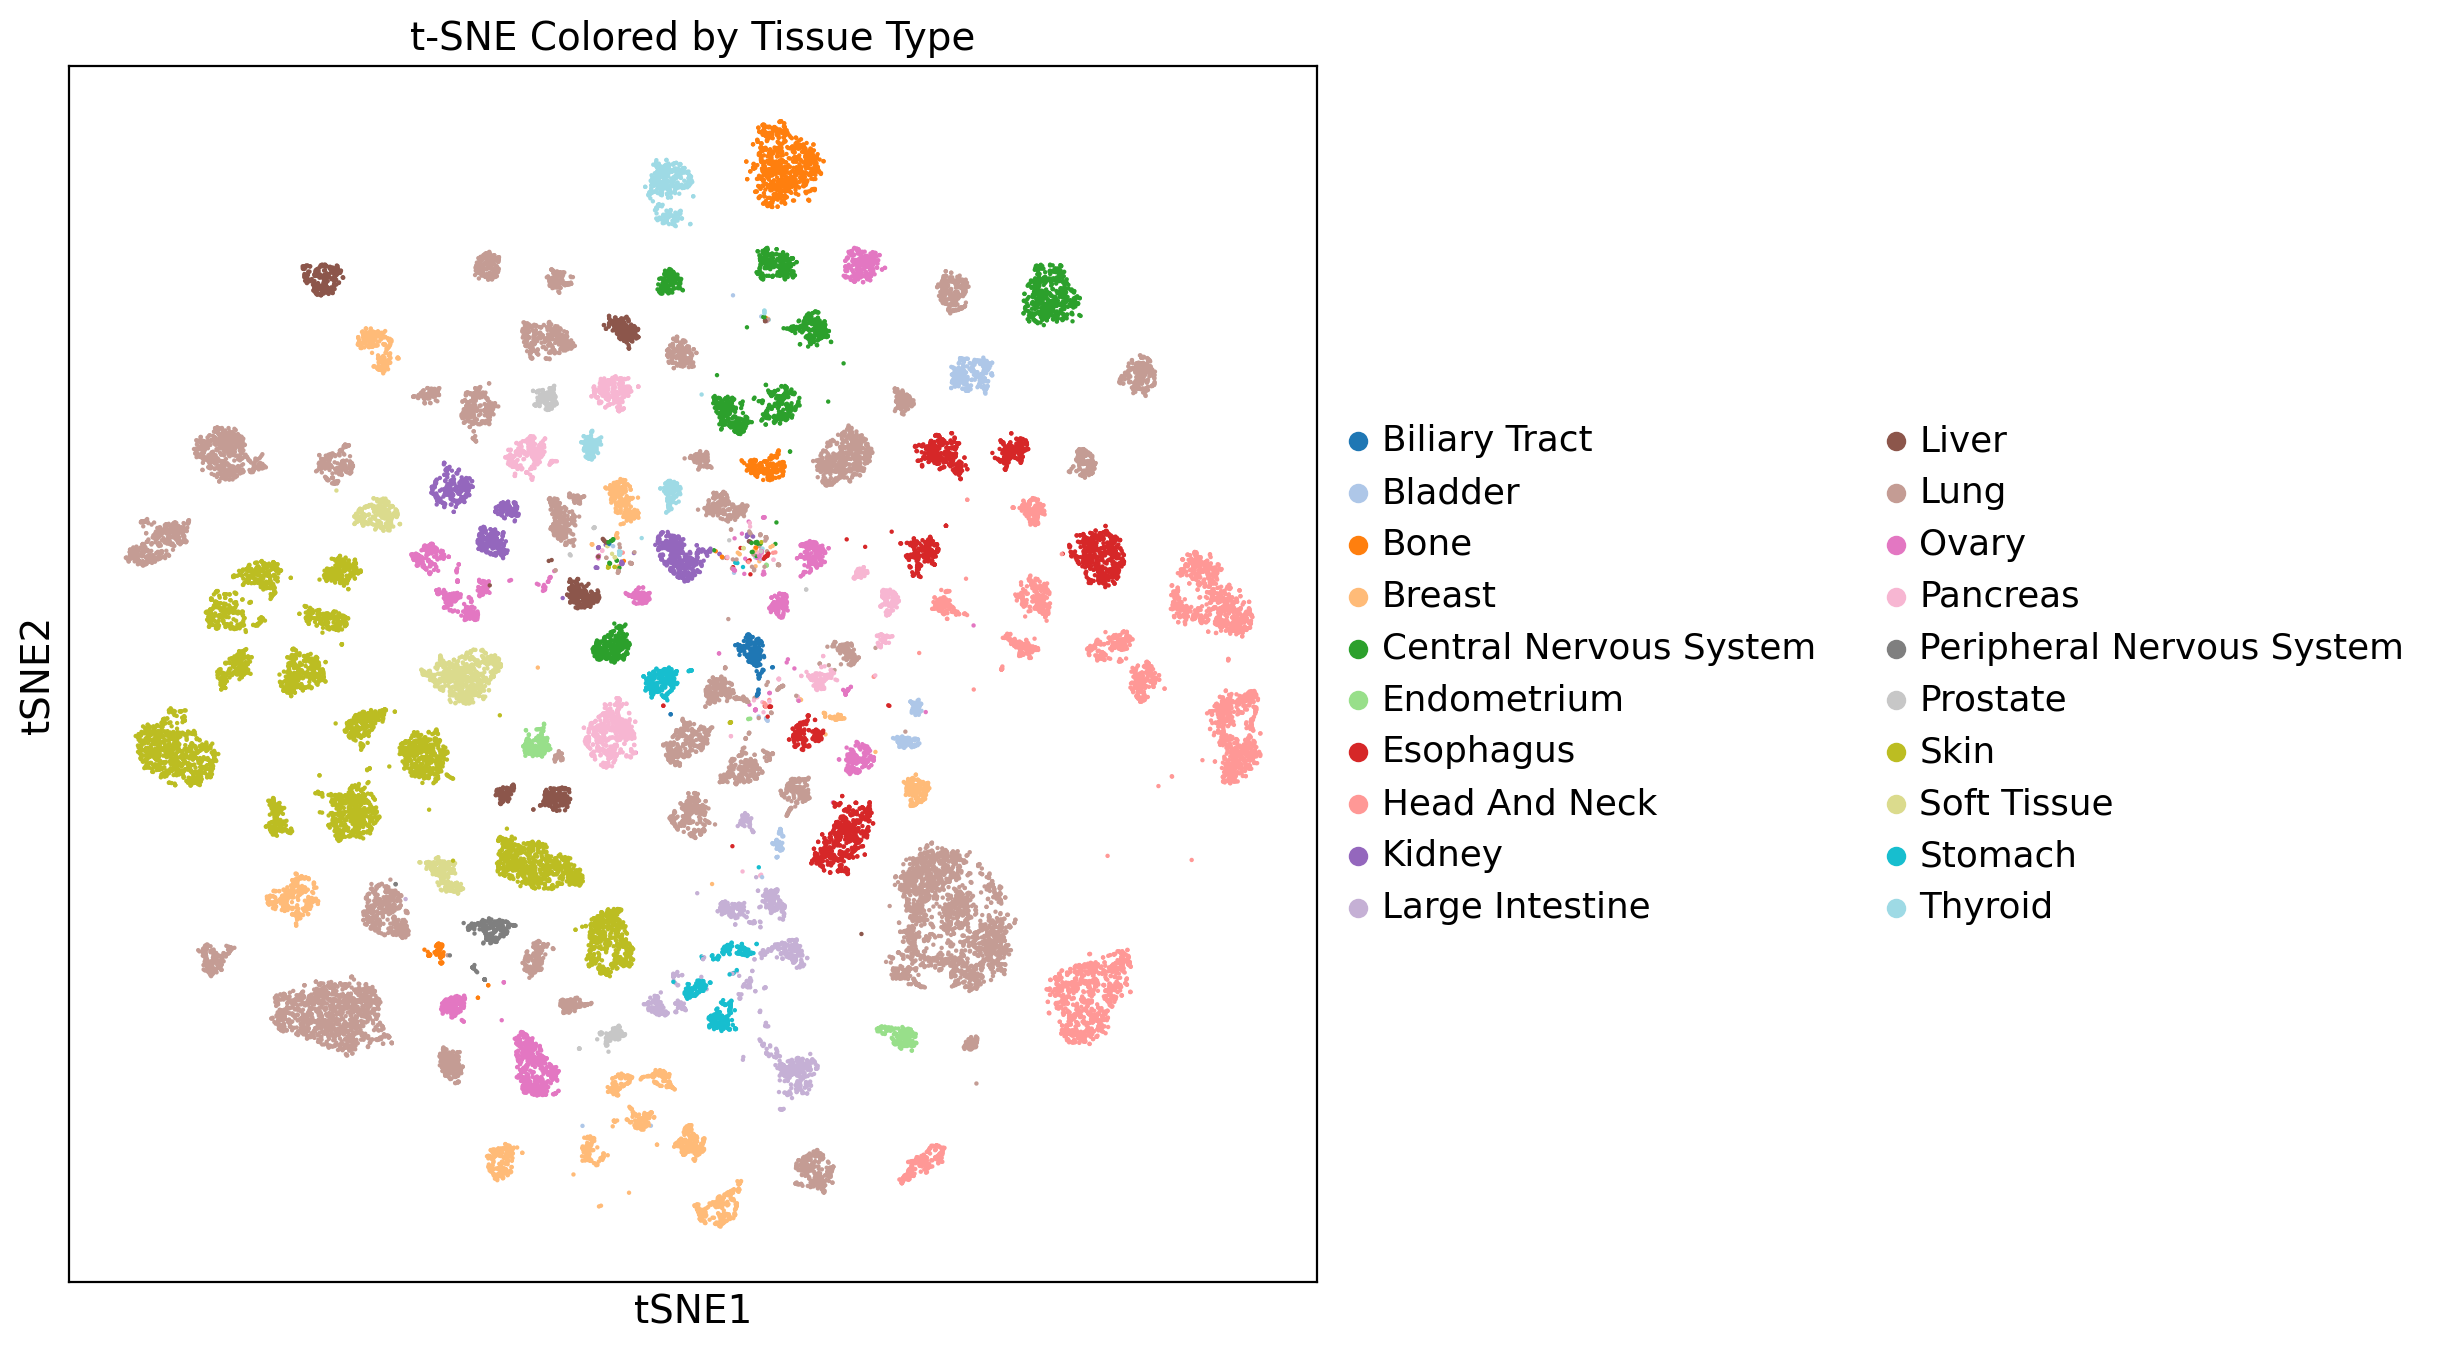

In [4]:
# 🎨 Visualize t-SNE colored by tissue
sc.pl.tsne(
    adata,
    color="Tissue",
    title="t-SNE Colored by Tissue Type",
    legend_loc="right margin",
    frameon=True,
    size=10,
    palette="tab20"
)


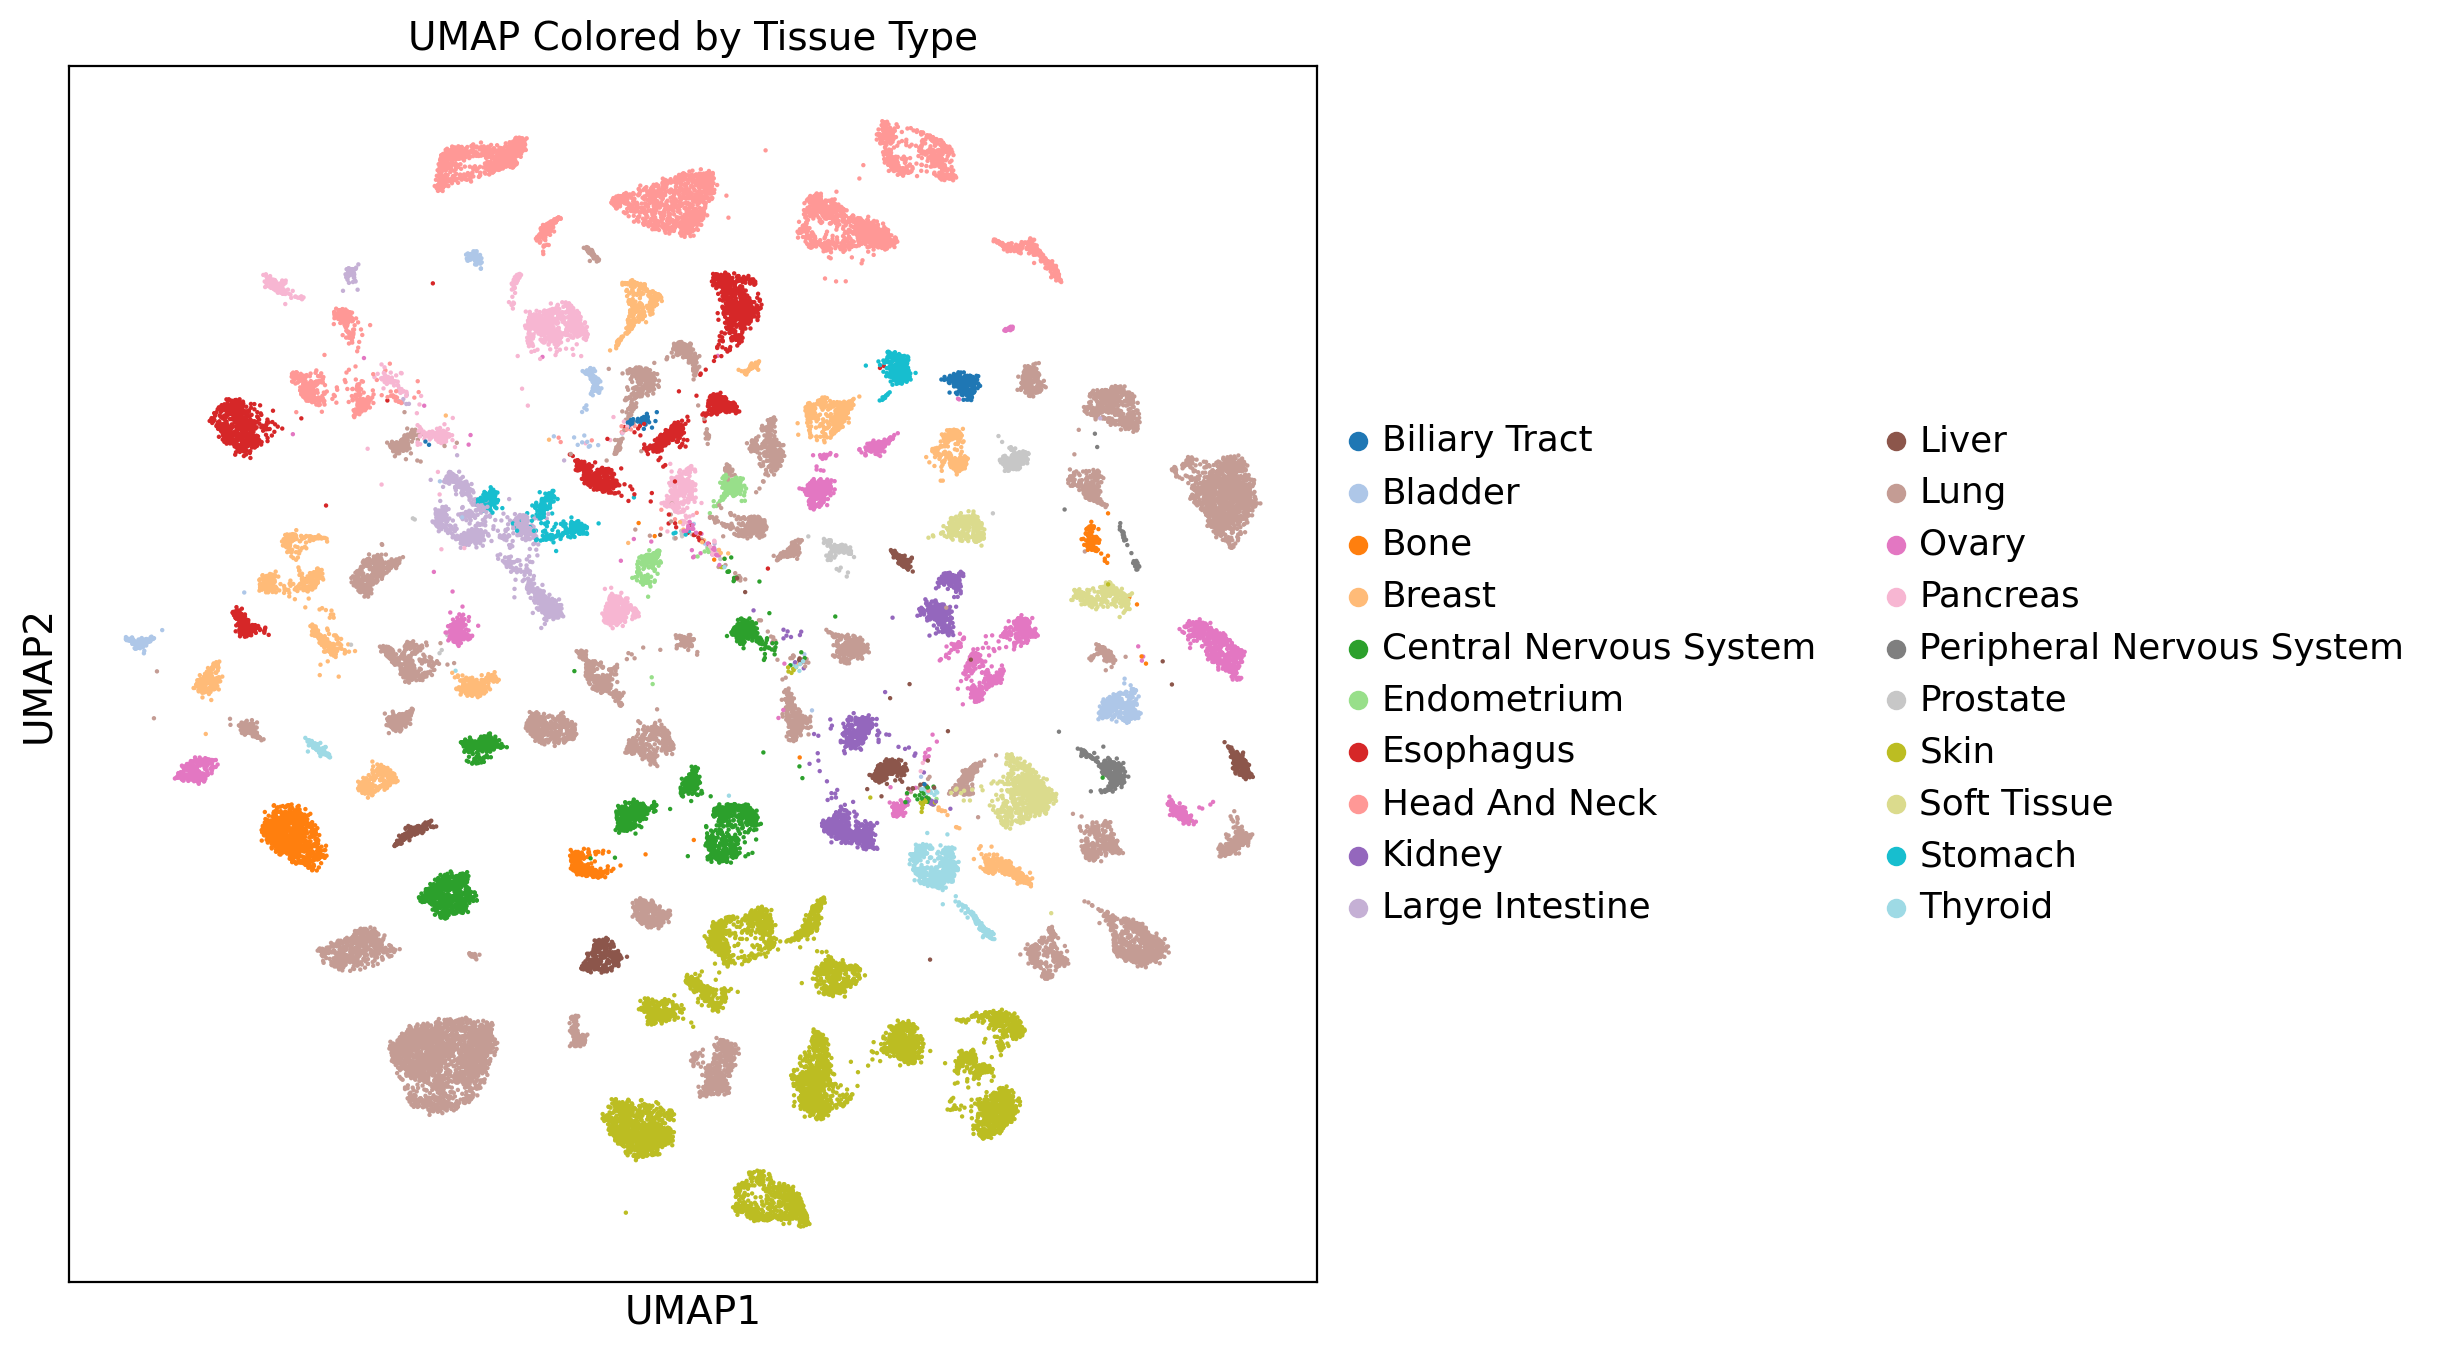

In [5]:
# 🧬 Compute UMAP if not available
if "X_umap" not in adata.obsm_keys():
    print("⚠️ UMAP not found, computing...")
    sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_pca")
    sc.tl.umap(adata)

# 🎨 Visualize UMAP colored by tissue
sc.pl.umap(
    adata,
    color="Tissue",
    title="UMAP Colored by Tissue Type",
    legend_loc="right margin",
    frameon=True,
    size=10,
    palette="tab20"
)


In [6]:
# 🩻 Check and add VIM and CDH1 expression from 'log1p_norm' layer
genes_of_interest = ["VIM", "CDH1"]
missing_genes = [gene for gene in genes_of_interest if gene not in adata.var_names]
print(f"🔍 Missing genes: {missing_genes}" if missing_genes else "✅ All genes present in AnnData.var_names.")

# Extract from 'log1p_norm' for stabilized visualization
vim_expr = adata[:, "VIM"].layers["log1p_norm"].toarray().flatten() if "VIM" in adata.var_names else np.zeros(adata.shape[0])
cdh1_expr = adata[:, "CDH1"].layers["log1p_norm"].toarray().flatten() if "CDH1" in adata.var_names else np.zeros(adata.shape[0])

# Add to .obs for seamless plotting
adata.obs["VIM_expr"] = vim_expr
adata.obs["CDH1_expr"] = cdh1_expr

print("✅ VIM and CDH1 expression gradients added to .obs for plotting.")


✅ All genes present in AnnData.var_names.
✅ VIM and CDH1 expression gradients added to .obs for plotting.


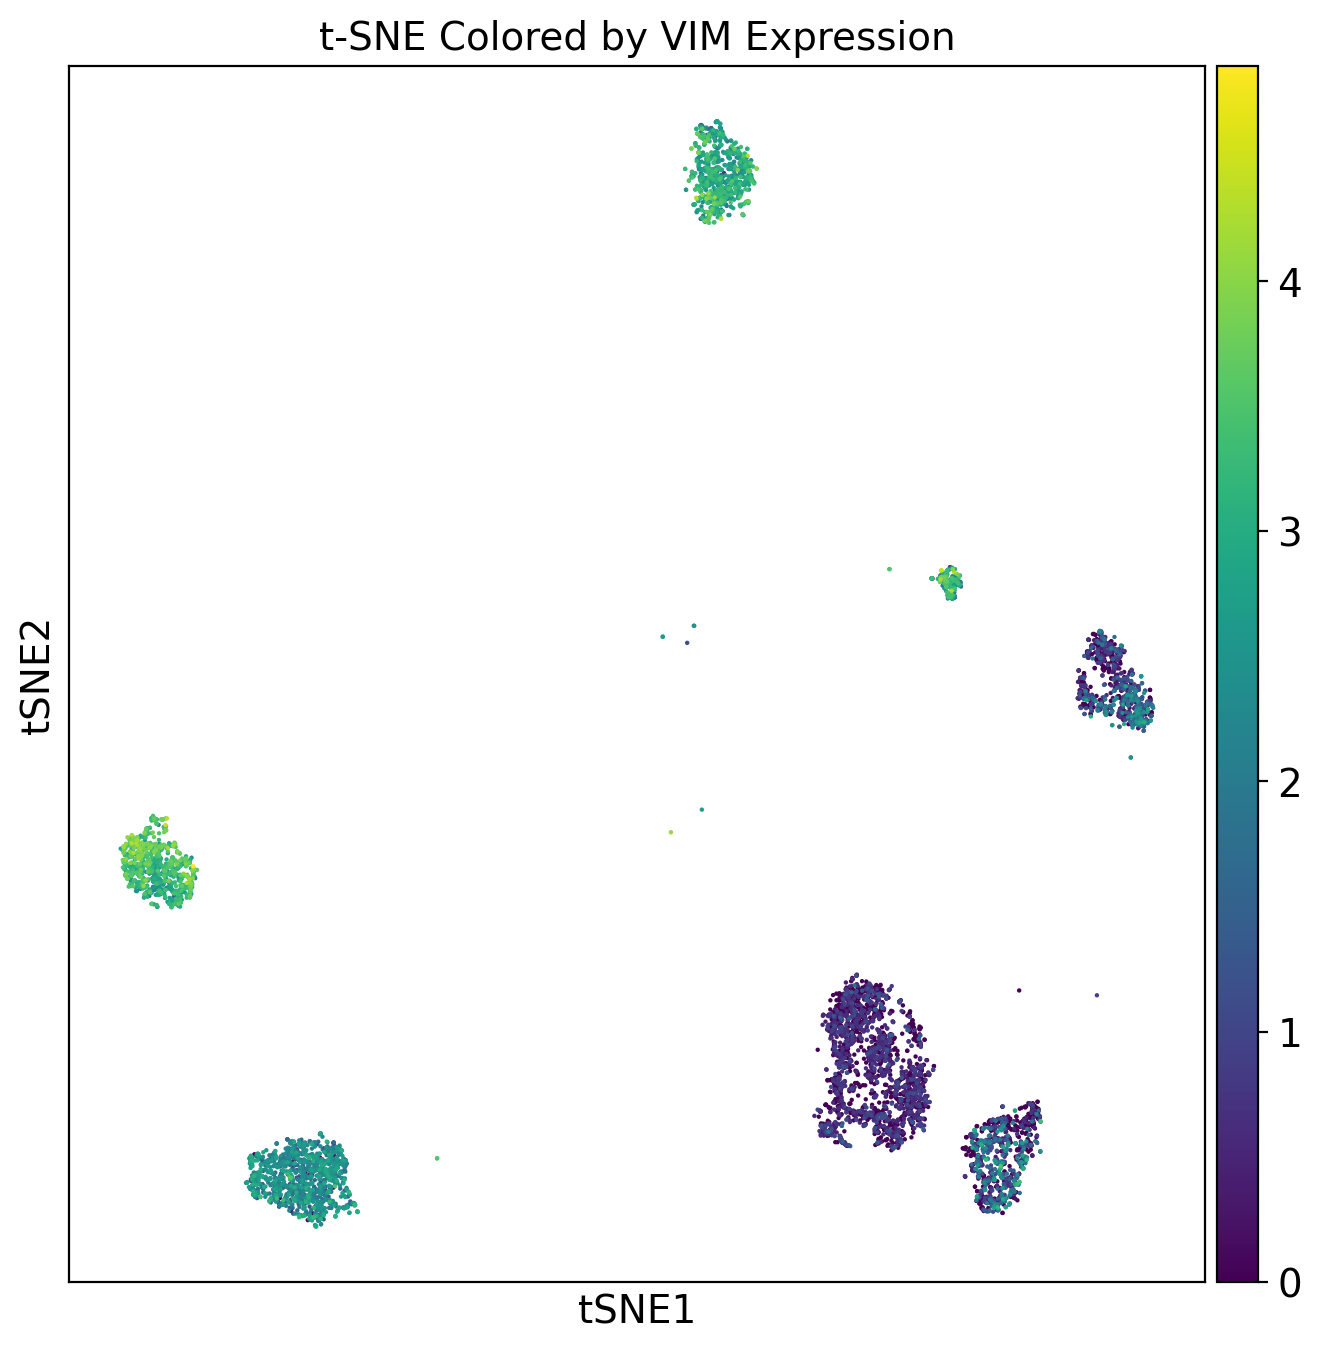

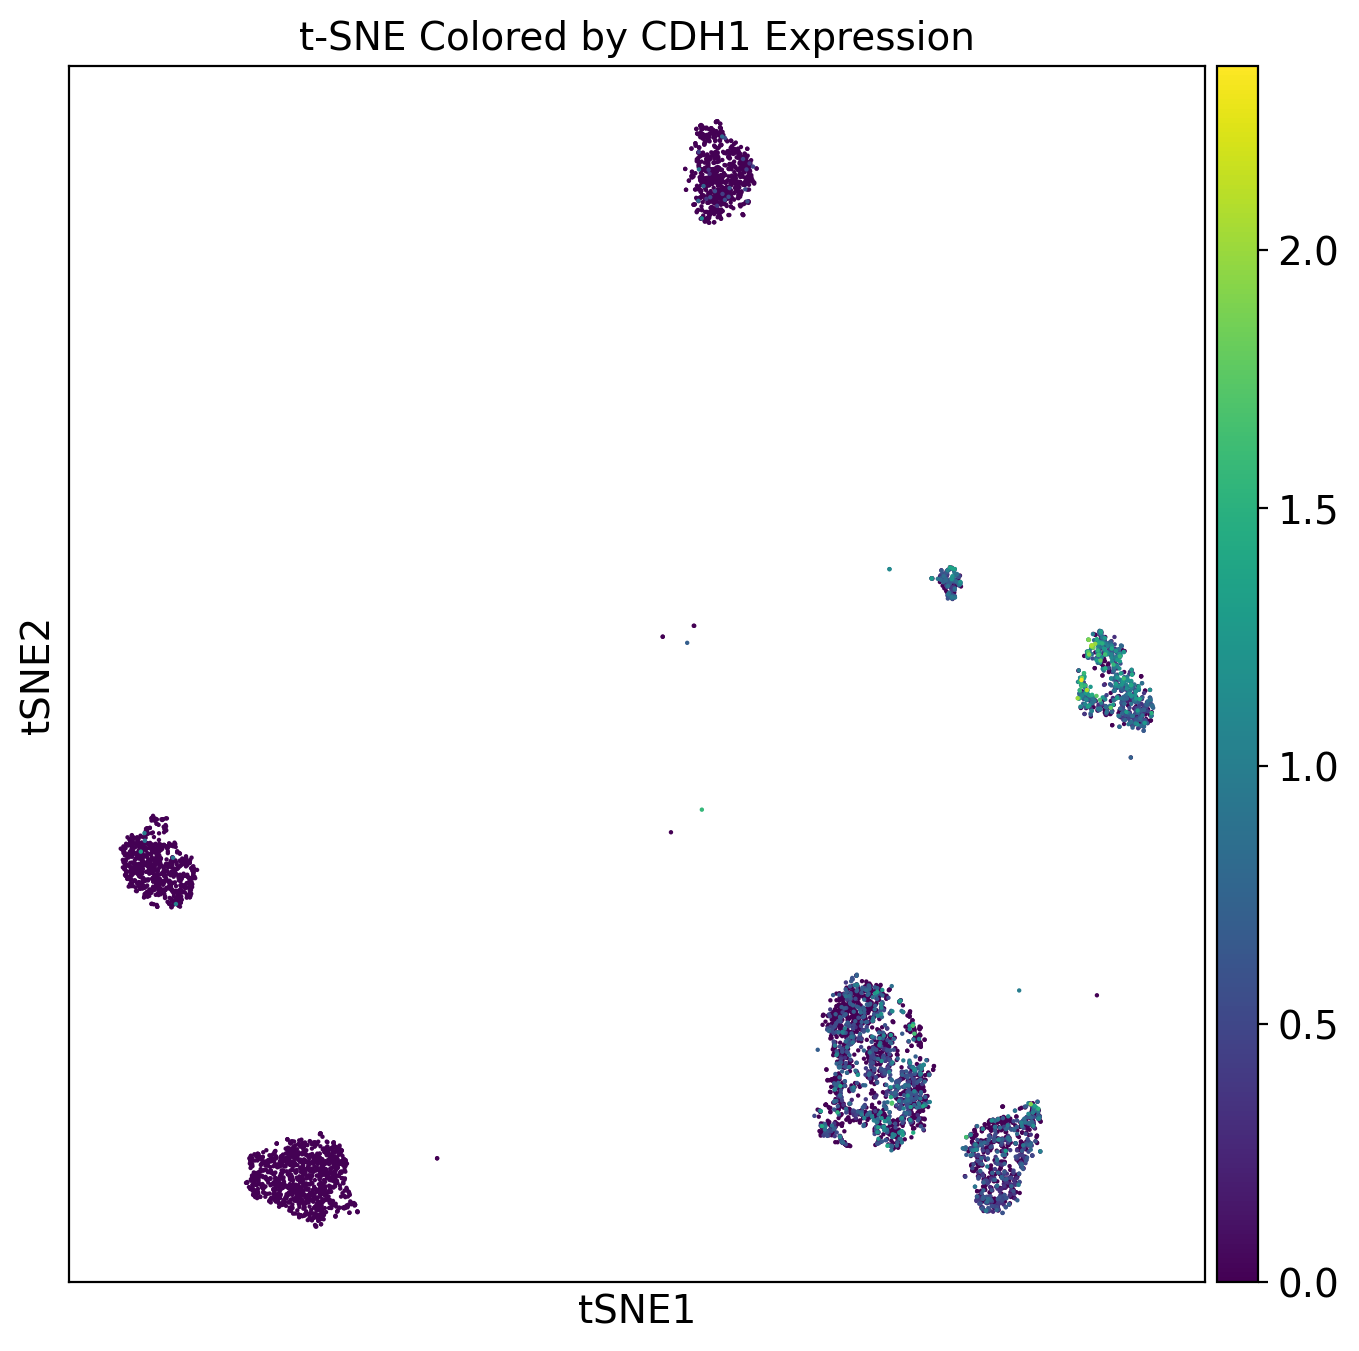

In [7]:
# 📊 Filter to top N cell lines for clear facet comparison
N = 6
top_cell_lines = adata.obs["cell_line"].value_counts().head(N).index.tolist()
adata_top = adata[adata.obs["cell_line"].isin(top_cell_lines)].copy()

# 🎨 t-SNE colored by VIM
sc.pl.tsne(
    adata_top,
    color="VIM_expr",
    groups=top_cell_lines,
    title="t-SNE Colored by VIM Expression",
    color_map="viridis",
    size=10,
    layer=None
)

# 🎨 t-SNE colored by CDH1
sc.pl.tsne(
    adata_top,
    color="CDH1_expr",
    groups=top_cell_lines,
    title="t-SNE Colored by CDH1 Expression",
    color_map="viridis",
    size=10,
    layer=None
)


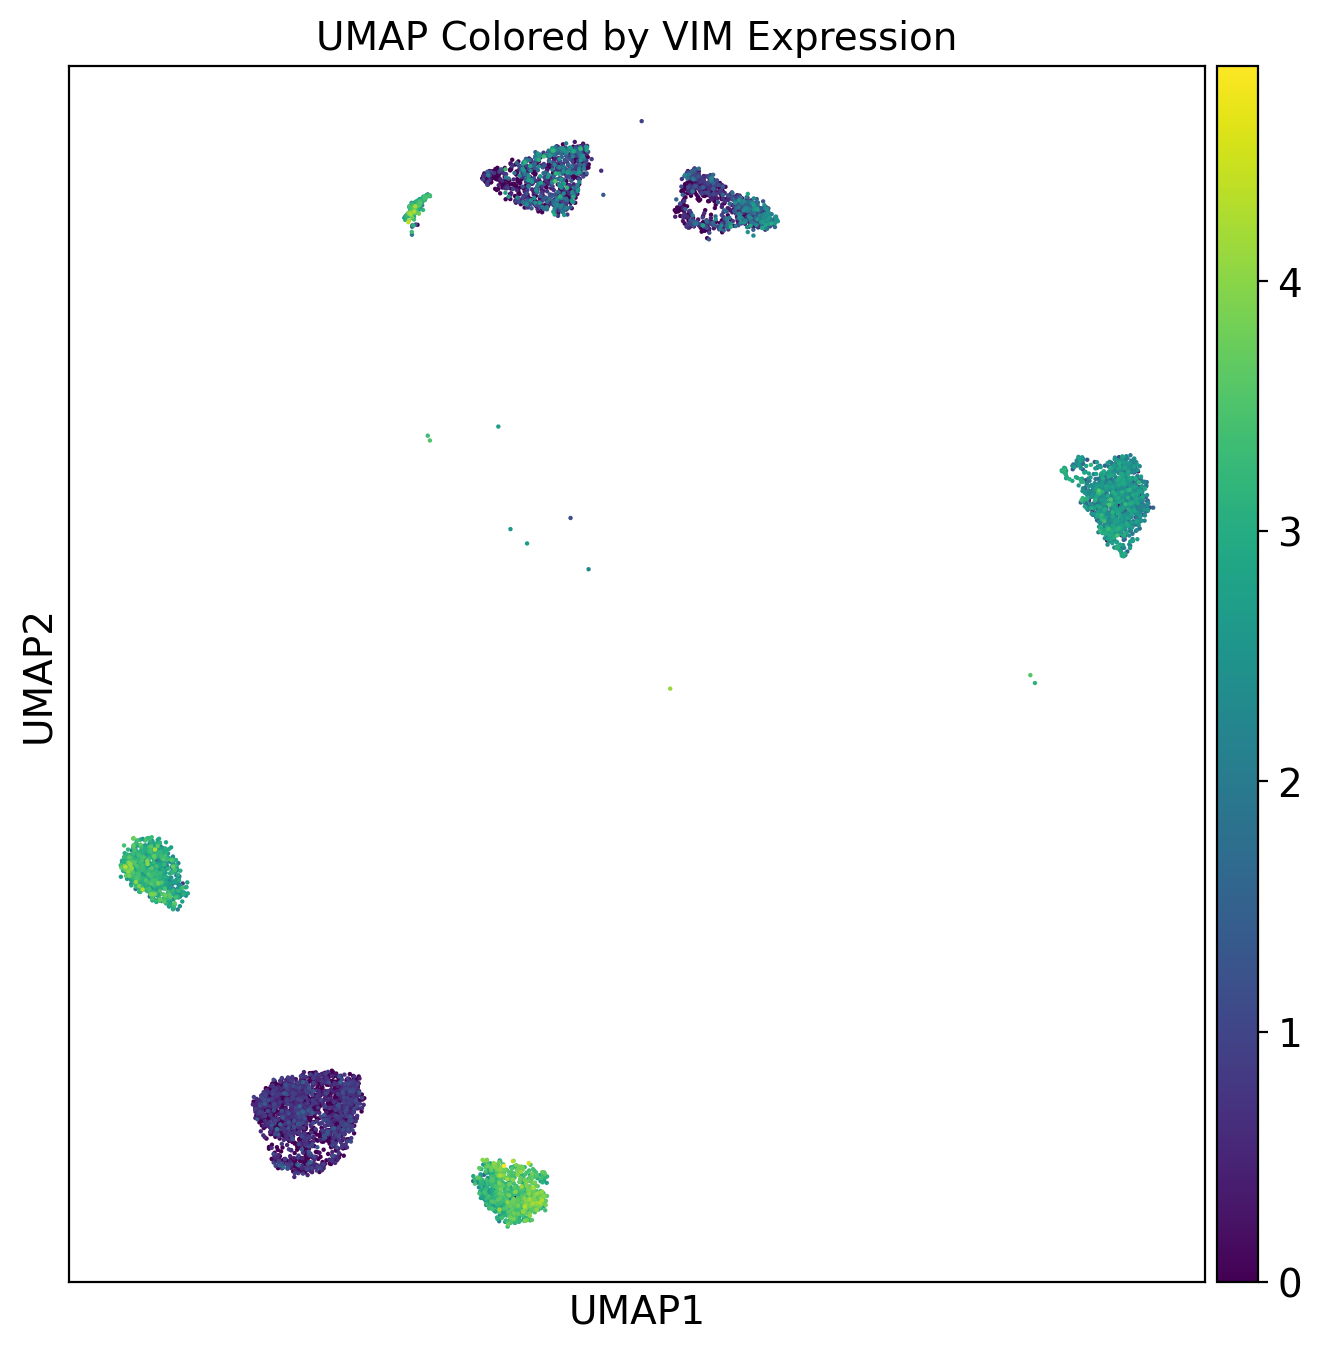

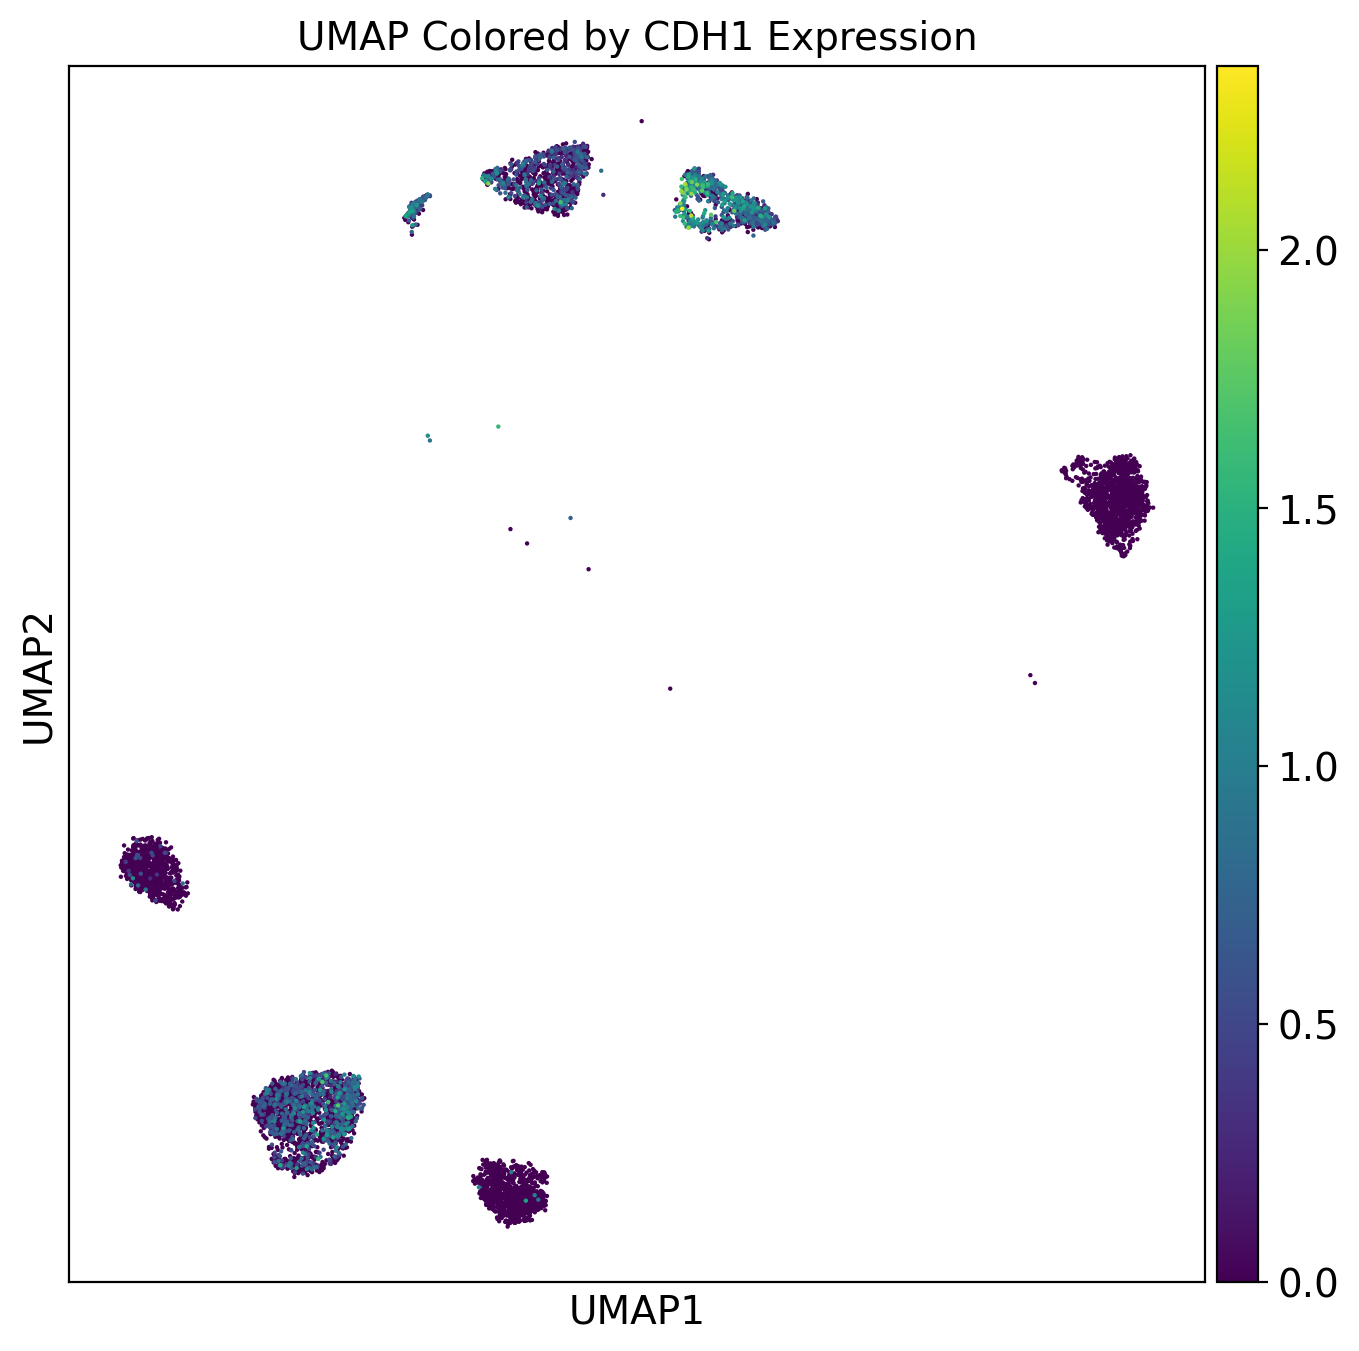

: 

In [ ]:
# 🎨 UMAP colored by VIM
sc.pl.umap(
    adata_top,
    color="VIM_expr",
    groups=top_cell_lines,
    title="UMAP Colored by VIM Expression",
    color_map="viridis",
    size=10,
    layer=None
)

# 🎨 UMAP colored by CDH1
sc.pl.umap(
    adata_top,
    color="CDH1_expr",
    groups=top_cell_lines,
    title="UMAP Colored by CDH1 Expression",
    color_map="viridis",
    size=10,
    layer=None
)
